Reading File:FinalRoll_ACNo_238PartNo_1.csv


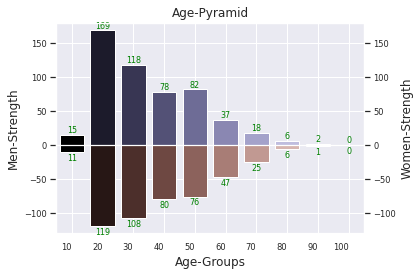

Reading File:FinalRoll_ACNo_238PartNo_2.csv


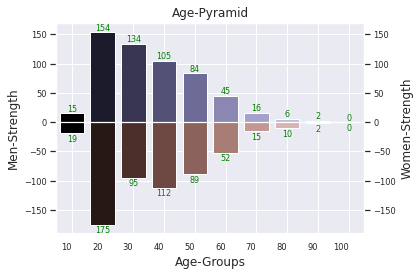

Reading File:FinalRoll_ACNo_238PartNo_3.csv


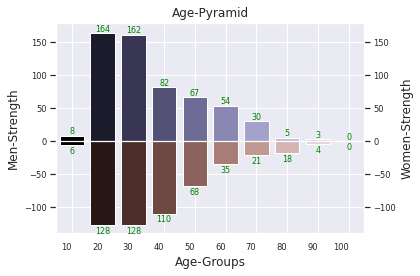

Reading File:FinalRoll_ACNo_238PartNo_4.csv


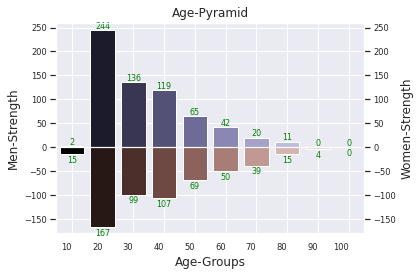

Reading File:FinalRoll_ACNo_238PartNo_5.csv


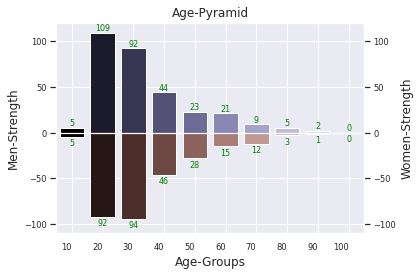

KeyboardInterrupt: 

In [11]:
import os
import pandas
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from google.cloud import storage
#from yattag import Doc, indent
#import pdfkit
#from pyvirtualdisplay import Display
#from combine import get_names_order

def get_names_order(filename):
    return int(filename.split('.')[0].split('_')[3])

def get_elem_count(bins, len):
    freq = list()
    for i in range(0, len):
        freq.append(bins.count(i))
    return freq

def gen_html(cwd, counter):
    doc, tag, text = Doc().tagtext()

    doc.asis('<!DOCTYPE html>')

    with tag('html'):
        with tag('body', id = 'hello'):
            with tag('h1'):
                text('Electorate Characteristics for Booth No:' + str(counter))
            with tag('table', klass='all-pr'):
                with tag('tr'):
                    with tag('td'):
                        with tag('h3'):
                            text('Gender Distribution:')
                        doc.stag('img', src=cwd+'/images/gender_charts/gen_'+str(counter)+'.png')
                    with tag('td'):
                        with tag('h3'):
                            text('Religion Distribution:')
                        doc.stag('img', src=cwd+'/images/rel_charts/rel_'+str(counter)+'.png')                    
                with tag('tr'):
                    with tag('td'):
                        with tag('h3'):
                            text('Caste Distribution:')
                        doc.stag('img', src=cwd+'/images/caste_charts/cst_'+str(counter)+'.png')
                    with tag('td'):
                        with tag('h3'):
                            text('Age Distribution:')
                        doc.stag('img', src=cwd+'/images/pyr/pyr_'+str(counter)+'.png')
            
    with open(cwd+'/tmp/index'+ str(counter) +'.html', "w") as index:
        index.write(indent(doc.getvalue(), indent_text = True))


def get_gender_pie(gen_cols, cwd, marker):
    counts = gen_cols.value_counts()
    if('तृतीय लिंग' in counts.index):
        res_count = counts.loc[['पुरूष', 'महिला', 'तृतीय लिंग']]
    else:
        res_count = counts.loc[['पुरूष', 'महिला']]
    res_df = res_count.to_frame()
    res_df.insert(0, 'Genders', list(res_count.index))

    res_df['Genders'].replace('पुरूष', 'Male', inplace=True)
    res_df['Genders'].replace('महिला', 'Female', inplace=True)
    res_df['Genders'].replace('तृतीय लिंग', 'Transgender', inplace=True)
    
    if(len(res_df.index)>2):
        explode = (0, 0, 0.1)
    else:
        explode = (0, 0)
    
    fig1, ax1 = plt.subplots(figsize=(4, 4))
    patches, texts, autotexts = ax1.pie(res_df[' Gender'], labels=res_df['Genders'], \
                                        autopct='%1.1f%%', explode = explode, startangle=90)
    ax1.axis('equal')  
    plt.tight_layout()
    plt.savefig(cwd+'/images/gender_charts/gen_'+marker+'.png')
    #plt.show()
    plt.close()


def get_caste_rel(caste_col, castes, cwd, marker):
    try:
        castes['Religion'].fillna('N', inplace=True)
        caste = caste_col.merge(castes, on='Title', how='left')
        c_freq = caste['Caste'].value_counts()
        c_freq.rename('Caste_Counts', inplace=True)
        if (len(caste_col.index) > c_freq.sum() and 'Others' in c_freq.index):
            c_freq['Others'] = c_freq['Others'] + len(caste_col.index) - c_freq.sum()
        elif (len(caste_col.index) > c_freq.sum()):
            others = pandas.Series([0], index=['Others'])
            c_freq.append(others)
            c_freq['Others'] = len(caste_col.index) - c_freq.sum()
        
        c_freq = c_freq.to_frame()
        c_freq.insert(0, 'Caste_Name', list(c_freq.index))
        
        c_freq.sort_values(['Caste_Counts'], ascending=(False), inplace = True)
        #c_freq.set_index(list(range(0, len(c_freq.index))), inplace = True)
        c_freq.reset_index(drop = True, inplace = True)
        
        if(len(c_freq.index) > 10):
            trunc = c_freq.truncate(before=0, after=10, copy = False)
        else:
            trunc = c_freq
        
        sns.set(style="darkgrid")
        ax = sns.barplot(x='Caste_Name', y='Caste_Counts', data = trunc, 
                         palette=sns.cubehelix_palette(len(trunc.index), start=2, rot=0, dark=0, light=.95, reverse=True)
                        )
        ax.set(xlabel='Castes', ylabel='Strength')
        plt.xticks(rotation=90,
                   horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-small'
                   )
        plt.yticks(horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-small'
                   )
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                            fontsize=8, color='green', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(cwd+'/images/caste_charts/cst_'+marker+'.png')
        plt.close()
        
        r_freq = caste['Religion'].value_counts(dropna = False)
        r_freq.rename('Rel_Counts', inplace=True)
        r_freq.rename(index={'N':'Non-Muslim', 'M': 'Muslim'}, inplace = True)
        r_freq = r_freq.to_frame()
        r_freq.insert(0, 'Religion_Name', list(r_freq.index))
        r_freq.dropna(axis=0, inplace = True)
        r_freq.reset_index(drop = True, inplace = True)
        
        colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
        fig1, ax1 = plt.subplots(figsize=(3.5, 3.5))
        patches, texts, autotexts = ax1.pie(r_freq['Rel_Counts'], colors = colors, labels=r_freq['Religion_Name'], \
                                        autopct='%1.1f%%', startangle=90)
        for text in texts:
            text.set_color('grey')
        for autotext in autotexts:
            autotext.set_color('grey')
        # Equal aspect ratio ensures that pie is drawn as a circle
        ax1.axis('equal')  
        plt.tight_layout()
        plt.savefig(cwd+'/images/rel_charts/rel_'+marker+'.png')
        plt.close()

        
    except Exception as e:
        print('Some error in analysis.' + str(e))
    
    return c_freq, r_freq
    
    
def get_age_tree(df, cwd, marker):
    men_age = df.loc[(df[' Age'] >= 18) & (df[' Gender'] == 'पुरूष'), [' Age']]
    women_age = df.loc[(df[' Age'] >= 18) & (df[' Gender'] == 'महिला'), [' Age']]
    
    cut_bins = [*range(10, 110, 10)]
    men_bins = pandas.cut(np.array(men_age[' Age']), bins = cut_bins, labels=False, retbins=False)
    women_bins = pandas.cut(np.array(women_age[' Age']), bins = cut_bins, labels=False, retbins=False)
    
    men_freq = get_elem_count(men_bins.tolist(), len(cut_bins))
    women_freq = get_elem_count(women_bins.tolist(), len(cut_bins))
    women_freq = [x * -1 for x in women_freq]
    
    age_range = list(range(10, 110, 10))
    y_min = math.floor(min(min(men_freq), min(women_freq))/10.0) * 10 - 10
    y_max = math.ceil(max(max(men_freq), max(women_freq))/10.0)  * 10 + 10
    
    cb_pd = pandas.DataFrame(cut_bins)
    men_pd = pandas.DataFrame(men_freq)
    women_pd = pandas.DataFrame(women_freq)
    
    bins = pandas.concat([cb_pd, men_pd, women_pd], axis=1, ignore_index=True)
    bins.rename(columns = {0:'Age-Groups', 1:'Men', 
                              2:'Women'}, inplace = True)
    
    fig = plt.figure()
    sns.set(style="darkgrid")
    ax1 = sns.barplot(x='Age-Groups', y='Men', data = bins,
                         palette=sns.cubehelix_palette(len(bins.index), start=3, rot=0, dark=0, light=.95, reverse=True)
                        )
    ax1.set(title='Age-Pyramid', xlabel='Age-Groups', ylabel='Men-Strength')
    plt.ylim(y_min, y_max)
    plt.xticks(horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-small'
                   )
    plt.yticks(horizontalalignment='right',
                   fontweight='light',
                   fontsize='x-small'
                   )
    ax1.tick_params(axis='y')
    ax1.grid(b=True, axis='both', linestyle='-')
    ax2 = ax1.twinx()
    ax2 = sns.barplot(x='Age-Groups', y='Women', data = bins,
                          palette=sns.cubehelix_palette(len(bins.index), start=1, rot=0, dark=0, light=.95, reverse=True)
                          )
    ax2.spines['bottom'].set_position('zero') 
    ax2.set(ylabel='Women-Strength')
    plt.ylim(y_min, y_max)
    ax2.grid(None)
    plt.yticks(horizontalalignment='left',
                   fontweight='light',
                   fontsize='x-small'
                   )
    
    for p in ax1.patches:
        ax1.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                            fontsize=8, color='green', ha='center', va='bottom')
    
    for p in ax2.patches:
        ax2.text(p.get_x() + p.get_width()/2., p.get_height()-2, '%d' % int(-p.get_height()), 
                            fontsize=8, color='green', ha='center', va='top')
    
    plt.tight_layout()
    plt.savefig(cwd+'/images/pyr/pyr_'+marker+'.png')
    plt.show()
    plt.close()
    
    #####
    #layout = go.Layout(yaxis=go.layout.YAxis(title='Age Groups'),
    #               xaxis=go.layout.XAxis(
    #                   range = [x_min, x_max],
    #                   tickvals = [*range(x_min, x_max, 10)],
    #                   ticktext = [*range(x_min, x_max, 10)],
    #                   title='Age Count'),
    #               barmode='overlay',
    #               bargap=0.1)
    
    #data = [go.Bar(
    #				y = age_range,
    #				x = men_freq,
    #				orientation = 'h',
    #				name = 'Men',
    #				hoverinfo = 'x',
    #				text = np.asarray(men_freq).astype('int'), 
    #				marker = dict(color = 'powderblue'),
    #				textposition = 'auto'
    #				),
    #				
    #		go.Bar(
    #				y = age_range,
    #				x = women_freq,
    #				orientation = 'h',
    #				name = 'Women',
    #				text = -1 * np.asarray(women_freq).astype('int'),
    #				hoverinfo = 'text',
    #				marker = dict(color = 'seagreen'),
    #				textposition = 'auto'
    #				)
    #		]
    
    #py.sign_in('vishalvivek', 'zDwV9l36XsujR6b0bjt6')
    #fig = go.Figure(data = data, layout = layout)
    #py.image.save_as(fig, cwd+'/images/pyr/age_pyramid'+str(serial)+'.png')
    #fig.write_image(cwd+"images/pyr/age_pyramid"+str(serial)+".png")
    #py.plot(dict(data = data, layout = layout), filename = 'bay_pyramid.html', \
    #		image_filename = 'test_bar_pyramid', image = 'png')

if __name__ == '__main__':
    storage_client = storage.Client.from_service_account_json('/home/vishalvivek8/key.json')
    bucket = storage_client.bucket('raw_images_ocr')
    blobs = bucket.list_blobs(prefix = 'outputs/')
    cwd = os.getcwd()
    
    output_files = list()
    
    for blob in blobs:
        if(blob.name == 'outputs/' or blob.name.startswith('outputs/ACNo')):
            continue
        output_files.append(blob.name.replace('outputs/', ''))
    
    output_files.sort(key = get_names_order)
    
    master_caste_file = open(cwd+'/dict/238_caste_linkage.csv')
    master = pandas.read_csv(master_caste_file, header = 0, sep = ',', encoding = 'utf8', error_bad_lines = False)
    
    #display = Display(visible=0, size=(1360,768))
    #display.start()
    
    counter = 1
    for file in output_files:
        try:
            blob = bucket.blob('outputs/'+file)
            blob.download_to_filename(file)
            print ("Reading File:" + file)
            dataframe = pandas.read_csv(file, header = 0, sep = ',', encoding = 'utf8', error_bad_lines = False)
            #print(dataframe.columns.values)
            
            marker = file.split('.')[0].split('_')[3]
            
            get_age_tree(dataframe, cwd, marker)
            get_gender_pie(dataframe[' Gender'], cwd, marker)           
            ind_castes = pandas.concat([dataframe[' Voter Surname']], axis = 1, keys=['Title'])
            get_caste_rel(ind_castes, master, cwd, marker)
            
            #Generating PDF on a Server with PDFKIT is a headache. hence putting all these files on GCC and moving on
            #gen_html(cwd, counter)
            
            #options = {
            #            'quiet': '',
            #            'page-size': 'Letter',
            #            'margin-top': '0.75in',
            #            'margin-right': '0.75in',
            #            'margin-bottom': '0.75in',
            #            'margin-left': '0.75in',
            #            'encoding': "UTF-8",
            #            'custom-header' : [
            #                ('Accept-Encoding', 'gzip')
            #            ],
            #            'no-outline': None
            #           }
            #config = pdfkit.configuration(wkhtmltopdf="/usr/bin/wkhtmltopdf")
            #pdfkit.from_file(cwd+'/tmp/index'+str(counter)+'.html', \
            #                 cwd+'/pdfs/elct_rsrch'+str(counter)+'.pdf', configuration=config, options=options)
            
            
            save_blob = bucket.blob('analysis/images/pyr/pyr_'+marker+'.png')
            save_blob.upload_from_filename(cwd+'/images/pyr/pyr_'+marker+'.png')
            save_blob = bucket.blob('analysis/images/gender_charts/gen_'+marker+'.png')
            save_blob.upload_from_filename(cwd+'/images/gender_charts/gen_'+marker+'.png')
            save_blob = bucket.blob('analysis/images/caste_charts/cst_'+marker+'.png')
            save_blob.upload_from_filename(cwd+'/images/caste_charts/cst_'+marker+'.png')
            save_blob = bucket.blob('analysis/images/rel_charts/rel_'+marker+'.png')
            save_blob.upload_from_filename(cwd+'/images/rel_charts/rel_'+marker+'.png')            
        
        except Exception as e:
            print (str(e))
        
        finally:
            counter = counter + 1
            os.remove(file)